참고 tutorial : https://nbviewer.jupyter.org/gist/subinium/26d22a786b0b7d088da63a97bf8e1d44    <br>
DATA : https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231#GOOGL_2006-01-01_to_2018-01-01.csv

## What I learned
* parse_dates : 날짜컬럼을 datetime 형태로 만들어줌
* fillna() 메서드의 ffill 매개변수, bfill매개변수 
    * ffill 매개변수 : 결측값을 앞 방향으로 채워나감
    * bfill 매개변수 : 결측값을 뒷 방향으로 채워나감
* asfreq 메서드 : 시계열을 특정 frequency로 변환 (30S = 30초, M = 매월) 
* plt.savefig : png파일로 이미지 저장
* 컬럼별로 subplot 그릴때
    * data.plot(subplots=True, figsize=(10,10))
* rcParams 설정을 활용하면, 차트의 크기와 선의 색, 두께등의 기본 값을 설정할 수 있다.
    * plt.rcParams["figure.figsize"] = (14,4)
* 

In [203]:
import plotly
plotly.__version__

'4.0.0'

In [214]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
#import plotly.plotly as py
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm

from numpy.random import normal, seed

from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA

import math
from sklearn.metrics import mean_squared_error
# plotly.__version__
print(os.listdir("./"))

['monthly data.csv', 'daily data.csv', 'MCD_2006-01-01_to_2018-01-01.csv', 'monthly data_filter.csv', 'ARIMA_monthly data.ipynb', 'weekly data.csv', 'stocks.png', '.ipynb_checkpoints', 'ARIMA_related theory.ipynb', 'weekly data_filter.csv', 'TimeSeries_ref.ipynb', 'pressure.csv', 'GOOGL_2006-01-01_to_2018-01-01.csv', 'humidity.csv', 'ARIMA_weekly data.ipynb']


* 1. Introduction to date and time
    * 1.1 Importing time series data
    * 1.2 Cleaning and preparing time series data
    * 1.3 Visualizing the datasets
    * 1.4 Timestamps and Periods
    * 1.5 Using date_range
    * 1.6 Using to_datetime
    * 1.7 Shifting and lags
    * 1.8 Resampling
* 2. Finance and Statistics
    * 2.1 Percent change
    * 2.2 Stock returns
    * 2.3 Absolute change in successive rows
    * 2.4 Comaring two or more time series
    * 2.5 Window functions
    * 2.6 OHLC charts
    * 2.7 Candlestick charts
    * 2.8 Autocorrelation and Partial Autocorrelation
* 3. Time series decomposition and Random Walks
    * 3.1 Trends, Seasonality and Noise
    * 3.2 White Noise
    * 3.3 Random Walk
    * 3.4 Stationarity
* 4. Modelling using statsmodels
    * 4.1 AR models
    * 4.2 MA models
    * 4.3 ARMA models
    * 4.4 ARIMA models
    * 4.5 VAR models
    * 4.6 State space methods
    * 4.6.1 SARIMA models
    * 4.6.2 Unobserved components
    * 4.6.3 Dynamic Factor models

# 1. Introduction to date and time
## 1.1 Importing time series data

### How to import data?
우선 이 커널에서 필요한 데이터셋을 불러와야합니다. pd.read_csv()에서 두 개의 매개변수를 사용해서 불러옵시다. <br>

parse_dates 매개변수를 사용하여 필요한 시계열을 datetime 열로 변환합니다. <br>
dataframe의 index는 index_col로 지정합니다.

#### Data being used:-
* Google Stocks Data (구글 주식 데이터)
* Humidity in different world cities (세계 여러 도시의 습도 데이터)
* Microsoft Stocks Data (마이크로소프트 주식 데이터)
* Pressure in different world cities (세계 여러 도시의 기압 데이터)

#### Data info
* Open - price of the stock at market open (this is NYSE data so all in USD)
* High - Highest price reached in the day
* Low Close - Lowest price reached in the day
* Volume - Number of shares traded
* Name - the stock's ticker name

In [17]:
google = pd.read_csv('./GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [26]:
humidity = pd.read_csv('./humidity.csv', index_col='datetime', parse_dates=['datetime'])
humidity.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,NaN,81.0,NaN,93.0,24.0,72.0,18.0,68.0,37.0,18.0,...,27.0,NaN,64.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,71.0,NaN,87.0,21.0,72.0,18.0,73.0,34.0,12.0,...,29.0,NaN,59.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,71.0,NaN,93.0,23.0,68.0,17.0,60.0,32.0,15.0,...,31.0,NaN,66.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 23:00:00,NaN,71.0,NaN,87.0,14.0,63.0,17.0,33.0,30.0,28.0,...,26.0,NaN,58.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30 00:00:00,NaN,76.0,NaN,75.0,56.0,72.0,17.0,23.0,34.0,31.0,...,32.0,NaN,58.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2 Cleaning and preparing time series data
구글 주식 데이터는 누락 데이터가 없지만, 습도 데이터는 누락데이터가 꽤 있습니다. <br>

누락 데이터는 fillna() 메서드와 ffill 매개변수를 이용해 채웁니다. fillna()의 매개변수는 다음과 같은 매개변수가 있습니다. 이는 후에도 언급하니 가볍게 넘어가면 될 것 같습니다.<br>

* ffill : 앞의 값을 관찰한 값으로 채워넣음
* bfill : 뒤의 값을 관찰한 값으로 채워넣음

In [27]:
humidity = humidity.iloc[1:]
humidity = humidity.fillna(method='ffill')
humidity.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,62.0,...,71.0,58.0,93.0,68.0,50.0,63.0,22.0,51.0,51.0,50.0
2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,91.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,87.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,62.0,...,69.0,57.0,84.0,68.0,52.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 17:00:00,78.0,79.0,84.0,79.0,88.0,80.0,21.0,24.0,49.0,63.0,...,69.0,57.0,80.0,68.0,54.0,62.0,23.0,51.0,51.0,50.0


## 1.3 Visualizing the datasets
asfreq 메서드는 시계열을 특정 frequency로 변환합니다. (30S = 30초, M = 매월) upsampling 또는 downsampling에 사용할 수 있습니다. <br>

여기서는 매개변수를 'M'으로 전달하였고, 이는 매월 빈도를 의미합니다.

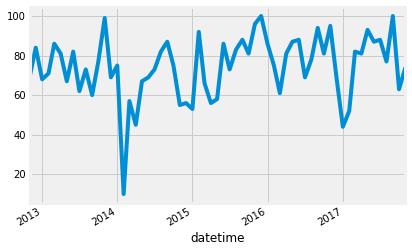

In [29]:
humidity['Kansas City'].asfreq('M').plot()

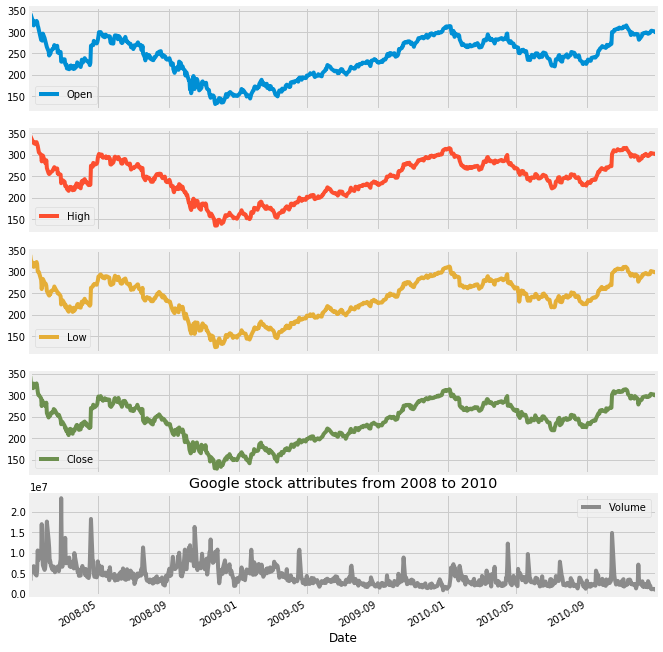

In [64]:
google['2008':'2010'].plot(subplots=True, figsize=(10,12))
plt.title('Google stock attributes from 2008 to 2010')
# png파일로 저장
plt.savefig('stocks.png')
plt.show()

## 1.4 Timestamps and Periods
timestamp와 period는 무엇이고, 어떻게 유용할까요?
* Timestamp는 특정 시점을 나타내기 위해 사용됩니다.
* Period는 특정 기간을 나타내기 위해 사용됩니다. <br>
Periods는 기간동안 특정 이벤트가 있는지 체크하는데 사용할 수 있습니다. 각각은 서로 변환가능합니다. 우선 아래 예시로 생성 방법을 살펴보겠습니다.

In [40]:
timestamp=pd.Timestamp(2017,1,1,12)
timestamp

Timestamp('2017-01-01 12:00:00')

In [46]:
period = pd.Period('2017-01-01')
period

Period('2017-01-01', 'D')

In [47]:
period.start_time < timestamp < period.end_time

True

In [48]:
# Converting timestamp to period
new_period = timestamp.to_period(freq='H')
new_period

Period('2017-01-01 12:00', 'H')

In [49]:
# Converting period to timestamp
news_timestamp = period.to_timestamp(freq='H', how='start')
news_timestamp

Timestamp('2017-01-01 00:00:00')

## 1.5 Using date_range
date_range는 무엇이고, 어떻게 유용할까요? <br>

date_range는 고정 frequency datetimeindex를 반환하는 메서드입니다. 이것도 예시를 봐야 이해가 빠를 것 같습니다.<br>
이는 기존 데이터에서 본인만의 시계열 요소를 만들거나 전체 데이터를 정리(arranging)하는데 사용할 수 있습니다.

In [50]:
# daily frequency
dr1 = pd.date_range(start='1/1/18', end='1/9/18')
dr1

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09'],
              dtype='datetime64[ns]', freq='D')

In [51]:
# monthly frequency
dr2 = pd.date_range(start='1/1/18', end='1/1/19', freq='M')
dr2

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='M')

In [52]:
# 특정 시작날짜를 정하지 않고, 구간값을 주고 datetimeindex를 만듬
dr3 = pd.date_range(end='1/4/2014', periods=8)
dr3

DatetimeIndex(['2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04'],
              dtype='datetime64[ns]', freq='D')

In [54]:
# 시작과 끝 날짜를 주고, 기간이주어졌을 때
dr4 = pd.date_range(start='2013-04-24', end='2014-11-17', periods=3)
dr4

DatetimeIndex(['2013-04-24', '2014-02-04', '2014-11-17'], dtype='datetime64[ns]', freq=None)

## 1.6 Using to_datetime
pandas.to_datetime()은 Dataframe을 datetime으로 변환하는 함수입니다.

In [55]:
df = pd.DataFrame({'year':[2015,2016], 'month':[2,3], 'day':[4,5]})
df

,year,month,day
0,2015,2,4
1,2016,3,5


In [56]:
df = pd.to_datetime(df)
df

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]

In [57]:
df=pd.to_datetime('01-01-2017')
df

Timestamp('2017-01-01 00:00:00')

## 1.7 Shifting and lags
우리는 원하는 기간을 shift하여 index를 원하는 frequency로 이동변환 가능합니다. <br>

이는 과거와 현재의 시계열을 비교하는데 유용합니다. <br>

아래는 데이터를 월 단위로 바꾼 후에 10개월을 shift한 후 시각화한 그래프입니다. <br>

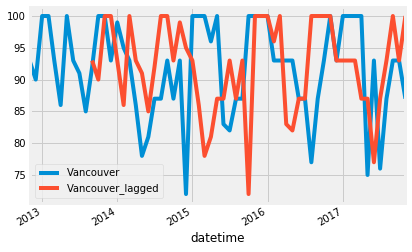

In [66]:
humidity['Vancouver'].asfreq('M').plot(legend=True)
shifted = humidity['Vancouver'].asfreq('M').shift(10).plot(legend=True)
shifted.legend(['Vancouver','Vancouver_lagged'])
plt.show()

## 1.8 Resampling
Upsampling : 시계열을 low frequency에서 high frequency로 변환(리샘플링)합니다. <br>
누락된 데이터를 채우거나 보간하는 방법을 포함합니다. (월 데이터 -> 일 데이터) <br>

Downsampling : 시계열을 high frequency에서 low frequency로 변환(리샘플링)합니다. <br>
기존 데이터를 집계하는 것을 포함합니다. (주간 데이터 -> 월 데이터)

In [75]:
pressure = pd.read_csv('./pressure.csv', index_col='datetime', parse_dates=['datetime'])
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1011.0,NaN,NaN,NaN
2012-10-01 13:00:00,NaN,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,1001.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 14:00:00,NaN,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,986.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 15:00:00,NaN,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,945.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 16:00:00,NaN,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,904.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0


In [76]:
pressure = pressure.iloc[1:]
pressure = pressure.fillna(method='ffill')
pressure.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,1021.0,1031.0,1013.0,1030.0,1016.0,1017.0,1021.0,1018.0,1025.0,1016.0,...,1021.0,1020.0,1021.0,1017.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 21:00:00,1021.0,1030.0,1013.0,1030.0,1016.0,1017.0,1020.0,1018.0,1024.0,1018.0,...,1021.0,1020.0,1023.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 22:00:00,1021.0,1030.0,1013.0,1029.0,1015.0,1016.0,1020.0,1017.0,1024.0,1018.0,...,1022.0,1020.0,1024.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 23:00:00,1021.0,1029.0,1013.0,1028.0,1016.0,1016.0,1020.0,1016.0,1024.0,1020.0,...,1023.0,1020.0,1026.0,1022.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-30 00:00:00,1021.0,1029.0,1013.0,1028.0,1015.0,1017.0,1019.0,1016.0,1024.0,1021.0,...,1024.0,1020.0,1027.0,1023.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0


In [77]:
pressure = pressure.fillna(method='bfill')
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,1001.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 14:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,986.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 15:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,945.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 16:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,904.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 17:00:00,807.0,1024.0,1009.0,1029.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,863.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0


* ffill 파라미터를 사용하면 마지막 유효 관측치를 전파하여 데이터의 갭을 채웁니다.
* bfill 파라미터를 사용하면 다음 유효 관측치를 전파하여 데이터의 갭을 채웁니다.

In [78]:
# Shape before resampling(downsampling)
pressure.shape

(45252, 36)

기존 데이터는 1시간 단위로 존재했습니다. 이를 3일 단위로 다운샘플링해보겠습니다. resample 메서드를 사용했고, 평균을 사용했습니다.

In [79]:
pressure = pressure.resample('3D').mean()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.000000,1013.000000,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.000000,1013.000000,990.083333
2012-10-07,1013.930556,1017.444444,1016.597222,1018.736111,1013.416667,1014.222222,1012.888889,1011.861111,1005.833333,1020.458333,...,1017.958333,1016.750000,1014.152778,1016.305556,982.972222,1013.027778,1007.555556,1013.000000,1013.000000,989.833333
2012-10-10,1015.000000,1015.430556,1014.833333,1018.416667,1010.694444,1014.013889,1000.166667,1005.611111,986.000000,984.486111,...,1018.694444,1017.916667,1016.166667,1017.319444,979.763889,1006.527778,998.763889,1012.333333,1012.333333,987.888889
2012-10-13,1008.152778,1018.111111,1021.069444,1015.930556,1017.277778,1018.375000,1015.666667,1015.500000,1013.625000,1010.444444,...,1025.055556,1024.388889,1020.805556,1023.736111,984.527778,1013.027778,1007.194444,1013.000000,1013.000000,990.430556


In [80]:
# Shape after resampling(downsampling)
pressure.shape

(629, 36)

이제 이를 역으로 3일간격을 1일 간격으로 업샘플링해보겠습니다. pad()는 패딩을 의미합니다.
* pad는 forward fill 과 같은 역할

In [81]:
pressure = pressure.resample('D').pad()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-02,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-03,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333
2012-10-05,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333


In [82]:
# Shape after resampling(upsampling)
pressure.shape

(1885, 36)

행의 수가 증가하지만, 데이터가 손실되는 것을 확인할 수 있었습니다. <br>

resampling은 필요에 따라 매우 유용하게 사용할 수 있습니다.

# 2. Finance and statistics
## 2.1 Percent change
시계열에서 각 데이터가 이전에 비해 변한 정도를 나타내는 코드입니다. <br>

shift()를 이용해 dataframe에서 최소 단위로 shift를 진행하고, div 메서드로 앞의 값을 나눠주는 방식입니다.

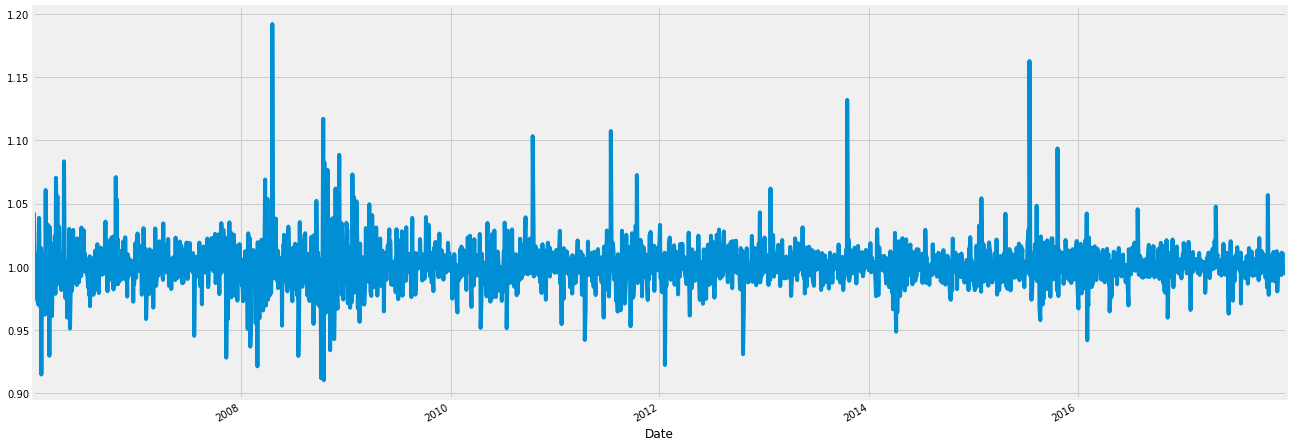

In [96]:
google['Change'] = google.High.div(google.High.shift())
google['Change'].plot(figsize=(20,8))

In [98]:
google.head()

,Open,High,Low,Close,Volume,Name,Change
Date,,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL,NaN
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL,1.030498
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL,1.005785
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL,1.041991
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL,1.006157


## 2.2 Stock returns
전과 price가 같다면, 변한 정도는 1로 표기될 것입니다. <br>

그렇기에 (비율-1) * 100 의 식을 사용하여 %로 변환합니다.

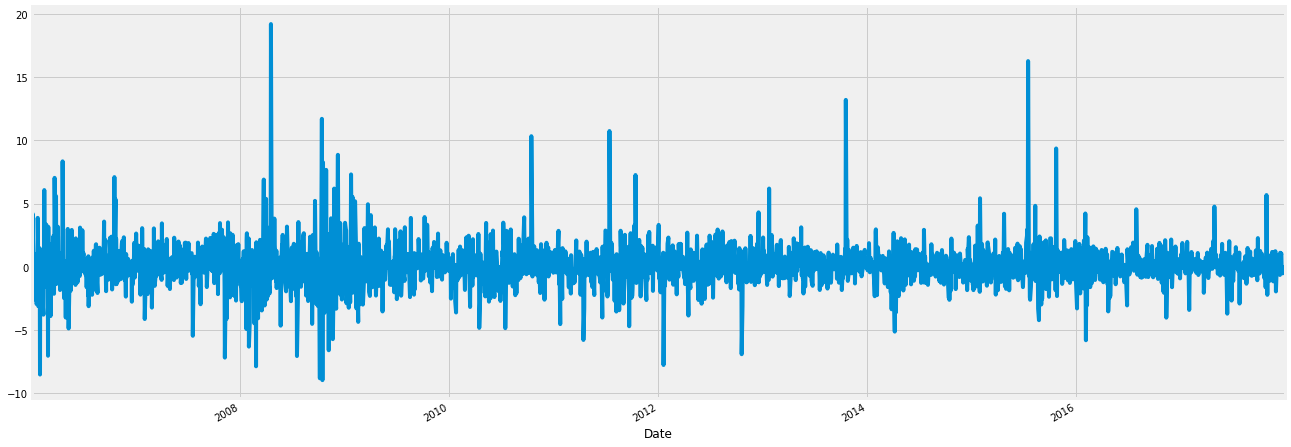

In [99]:
google['Return'] = google.Change.sub(1).mul(100)
google['Return'].plot(figsize=(20,8))
plt.show()

In [100]:
google.head()

,Open,High,Low,Close,Volume,Name,Change,Return
Date,,,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL,NaN,NaN
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL,1.030498,3.049759
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL,1.005785,0.578549
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL,1.041991,4.199115
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL,1.006157,0.615737


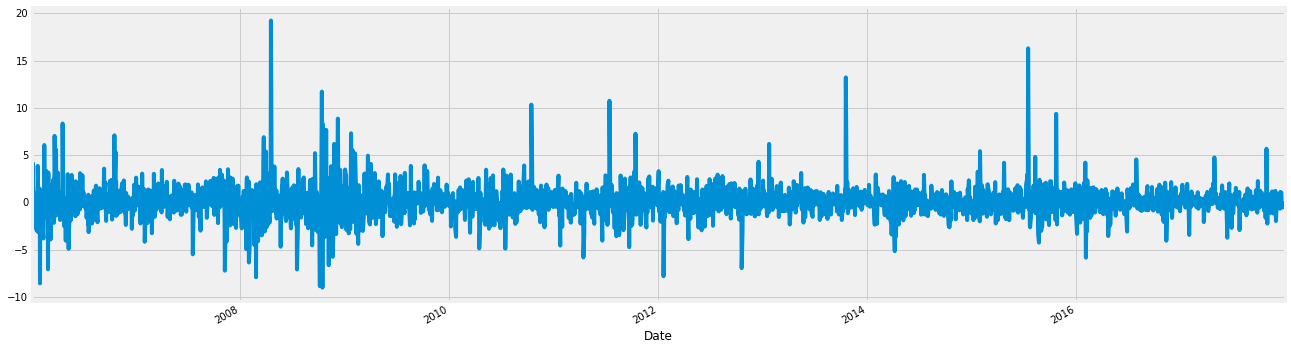

In [101]:
# 위 결과를 한줄로 작성할 경우
google.High.pct_change().mul(100).plot(figsize=(20,6)) # Another way to calculate returns

## 2.3 Absolute change in successive rows
값 자체의 차이는 diff()를 사용하여 구할 수 있습니다.

In [104]:
google.head()

,Open,High,Low,Close,Volume,Name,Change,Return
Date,,,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL,NaN,NaN
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL,1.030498,3.049759
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL,1.005785,0.578549
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL,1.041991,4.199115
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL,1.006157,0.615737


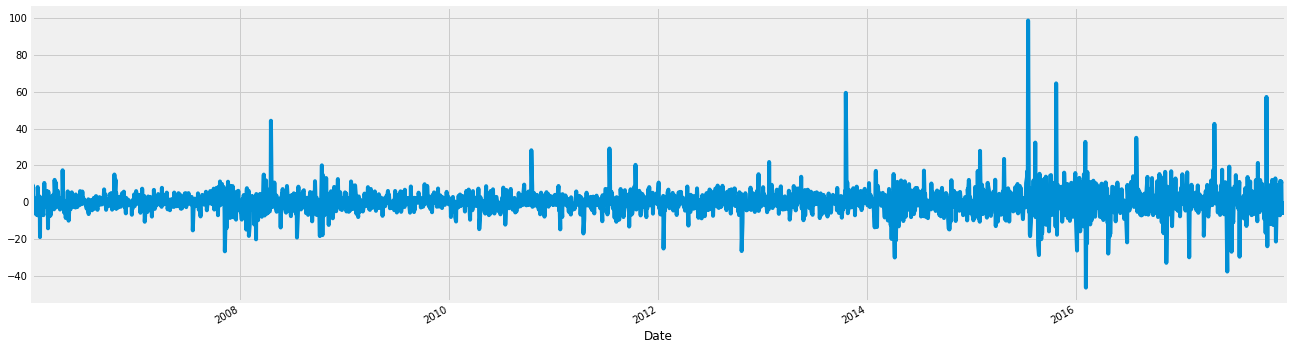

In [105]:
google.High.diff().plot(figsize=(20,6))

## 2.4 Comparing two or more time series
normalization을 통해 2개의 시계열을 비교해보겠습니다. <br>

두 개의 시계열을 각 시계열의 첫 번째 요소로 나누어주어, 비율의 변화를 보는 방법입니다. 두 시리즈의 시작점이 1.0으로 같아 비교가 용이합니다.<br>

이제 구글 주식과 함께 MS 주식 데이터를 불러오겠습니다.

In [106]:
mcd = pd.read_csv('./MCD_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

In [107]:
mcd.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,34.29,34.29,33.20,33.52,9250100,MCD
2006-01-04,33.43,33.85,33.42,33.82,5990300,MCD
2006-01-05,33.82,34.20,33.73,33.86,6245200,MCD
2006-01-06,34.23,34.30,33.81,34.06,5877100,MCD
2006-01-09,34.00,34.74,33.99,34.71,4659900,MCD


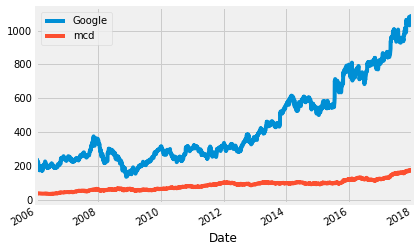

In [111]:
# Plotting before normalization
google.High.plot()
mcd.High.plot()
plt.legend(['Google','mcd'])
plt.show()

아래는 변환 후 그래프입니다.

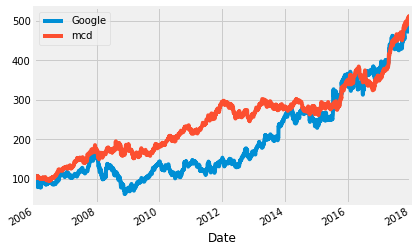

In [115]:
normalized_google=google.High.div(google.High.iloc[0]).mul(100)
normalized_mcd = mcd.High.div(mcd.High.iloc[0]).mul(100)
normalized_google.plot()
normalized_mcd.plot()
plt.legend(['Google','mcd'])
plt.show()

## 2.5 Window functions
Window functions는 서브-기간을 식별하고, 서브-기간간의 연산에 사용합니다.
* Rolling : 일정 구간에서 움직이며 값의 경향성을 구함
* Expanding : Contains all prior values <br>

아래는 각 데이터를 90일 window를 이동시키며 평균으로 ploting한 예시입니다.

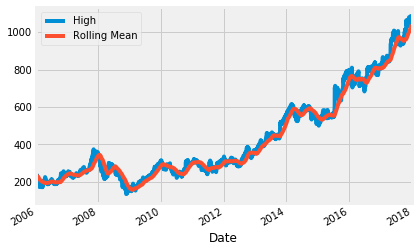

In [118]:
rolling_google=google.High.rolling('90D').mean()
google.High.plot()
rolling_google.plot()
plt.legend(['High','Rolling Mean'])
# Plotting a rolling mean of 90 day window with original High attribute of google stocks
plt.show()

원본보다 롤링한 값이 부드러운 것을 확인할 수 있습니다. <br>

아래는 expanding 예시입니다. default값은 1입니다.

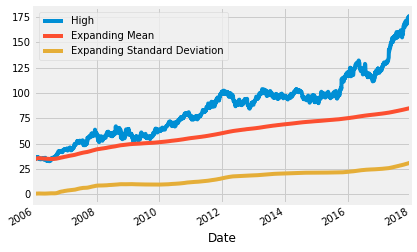

In [123]:
# Expanding window functions
mcd_mean = mcd.High.expanding().mean()
mcd_std = mcd.High.expanding().std()
mcd.High.plot()
mcd_mean.plot()
mcd_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

## 2.6 OHLC charts
plotly.graph_objs 모듈을 사용하여 Ohlc 차트를 그려보겠습니다.

In [173]:
import plotly 
plotly.offline.plot

<function plotly.offline.offline.plot(figure_or_data, show_link=False, link_text='Export to plot.ly', validate=True, output_type='file', include_plotlyjs=True, filename='temp-plot.html', auto_open=True, image=None, image_filename='plot_image', image_width=800, image_height=600, config=None, include_mathjax=False, auto_play=True, animation_opts=None)>

In [ ]:
trace = go.Ohlc(x=google['06-2008'].index,
                open=google['06-2008'].Open,
                high=google['06-2008'].High,
                low=google['06-2008'].Low,
                close=google['06-2008'].Close)
data = [trace]
iplot(data, filename='simple_ohlc')

## 2.8 Autocorrelation and Partial Autocorrelation
* Autocorrelation : The autocorrelation function (ACF)은 lags만큼 이동시킨 자기자신과의 공분산을 의미합니다. 정확히는 공분산을 normalization한 값입니다. 현재와 과거의 연관성을 확인할 수 있습니다. 자기상관이라고도 합니다.

* Partial Autocorrelation : 부분적인 autocorrelation을 의미합니다. 편자기상관함수라고도 불립니다. 시간단위로 구분된 시계열간의 자기상관도를 확인합니다. <br>

일반적으로 추세를 확인하고 이동 평균 매개 변수의 가능한 값을 추론하는 데 ACF를 사용하고 자동 회귀 부분에는 PACF를 사용합니다.

### Autocorrelation

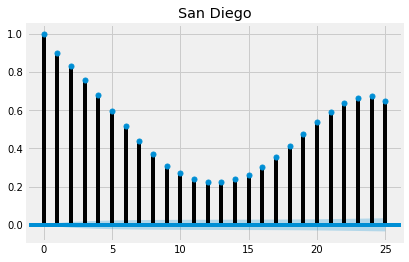

In [180]:
plot_acf(humidity['San Diego'], lags=25, title="San Diego")
plt.show()

모든 지연은 1에 가깝거나 또는 적어도 신뢰 구간보다 크므로 통계적으로 유의합니다.

### Partial Autocorrelation

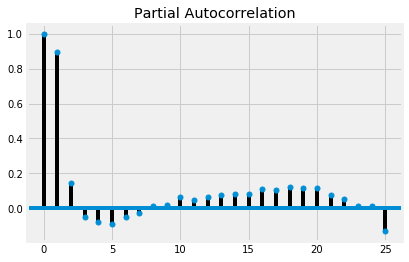

In [185]:
plot_pacf(humidity['San Diego'], lags=25)
plt.show()

처음 2개 이후 매우 낮은 값을 가집니다.

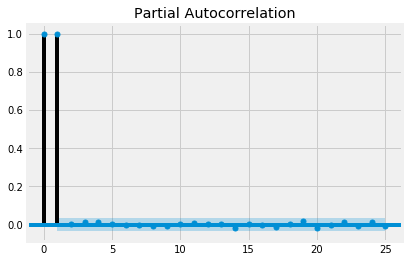

In [187]:
# Partial Autocorrelation of closing price of microsoft stocks
plot_pacf(mcd["Close"],lags=25)
plt.show()

여기서 0번째, 1번째 lags만 통계적으로 중요합니다.

# 3. Time series decomposition and Random walks
## 3.1 Trends, seasonality and noise
시계열에는 다음과 같은 요소가 있습니다.

* Trend : 시계열에서 일정한 상승 또는 하강 기울기
* Seasonality : 시계열에서 명확한 패턴 (사인함수와 같이)
* Noise : 특이점(Outliers) 또는 누락 데이터

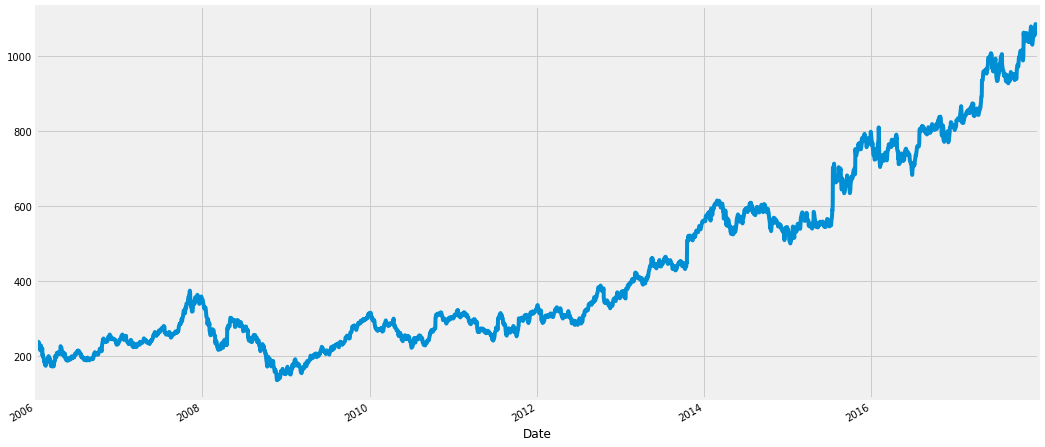

In [188]:
google['High'].plot(figsize=(16,8))
plt.show()

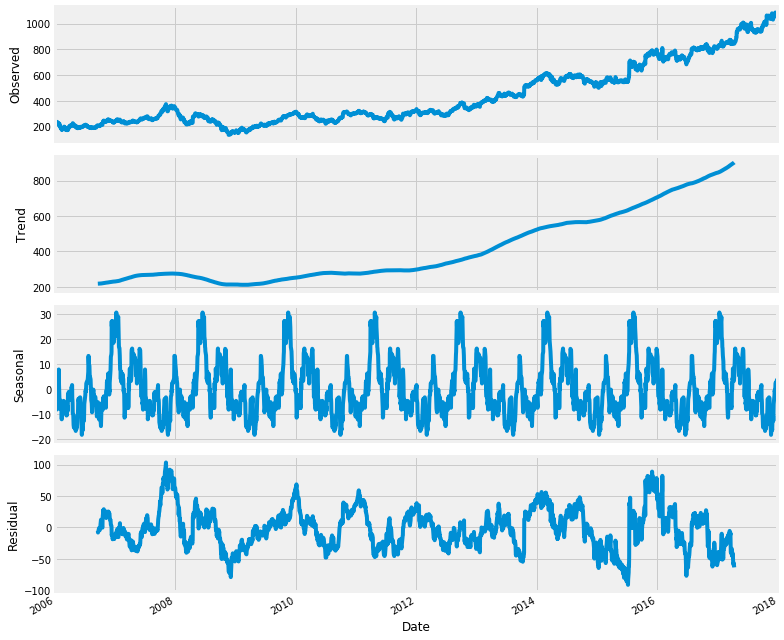

In [192]:
rcParams['figure.figsize'] = 11,9
decomposed_google_volume =sm.tsa.seasonal_decompose(google['High'], freq=360)
figure = decomposed_google_volume.plot()
plt.show()

* 위 그래프에서는 분명한 상승 trend가 있습니다.
* seasonal change는 균일한 것을 확인할 수 있습니다.
* 특이점과 누락 데이터는 균일하지 않은 것을 확인할 수 있습니다.

## 3.2. White noise
시계열 분석에서 White noise는 서로 독립적이고 평균과 분산이 일정한 잡음입니다. 자기상환함수나 편자기상관함수의 값이 유의수준보다 작으면 백색잡음으로 판단합니다. <br>

White noise는 다음과 같은 성질을 가지고 있습니다. 많은 수계열 모형들의 불규칙한 패턴을 의미하고, 정규분포에서 추출된 임의의 수치라고 규정하고 있습니다. 모델의 해석을 전반적으로 편리하게 만듭니다. <br>

* Constant mean : 일정한 평균
* Constant variance : 일정한 분산
* Zero auto-correlation at all lags : 모든 lag에 대해 자기상관계수가 0

아래는 white noise 예시입니다.

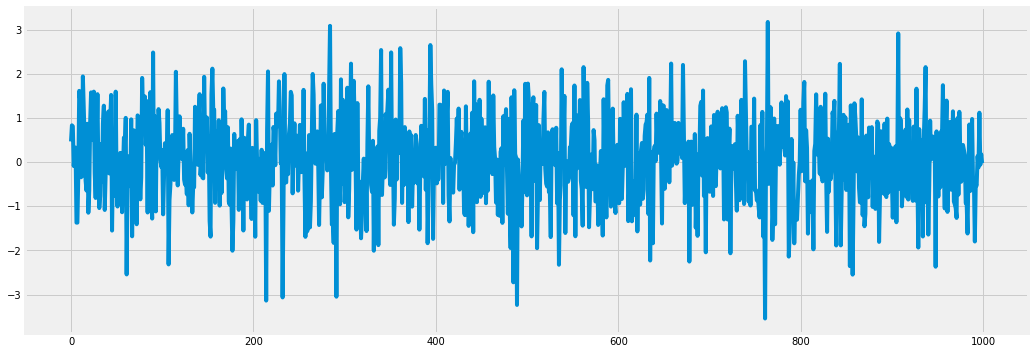

In [194]:
rcParams['figure.figsize'] = 16,6
white_noise = np.random.normal(loc=0, scale=1, size=1000)
# loc is mean, scale is variance
plt.plot(white_noise)

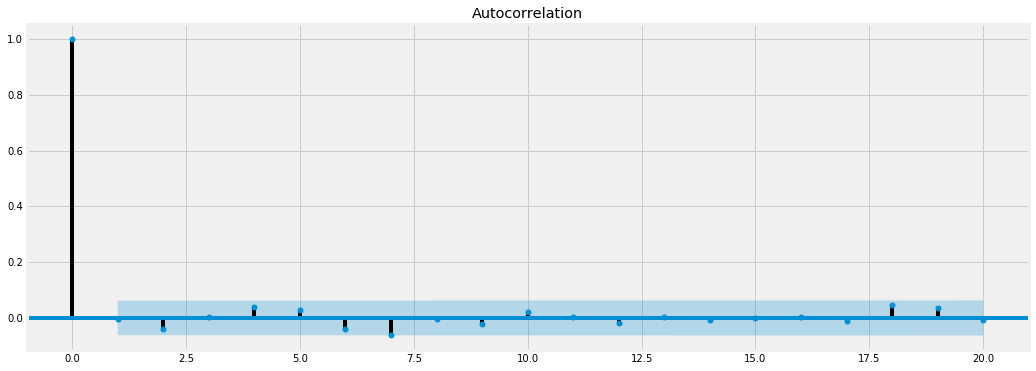

In [195]:
plot_acf(white_noise, lags=20)
plt.show()

## 3.3. Random Walk
random walk는 확률론적 랜덤 프로세스로, 단순한 시뮬레이션 입니다. 시계열에서 주식, 정수(integer)과 같은 수 단위의 시스템에서 다음 행동의 확률을 통해 미래를 예측하는 모델링입니다. <br>

주식에서는 보통 다음과 같은 형태가 나타납니다<br>

Today's Price = Yesterday's Price + Noise<br>

즉, 오늘의 가격은 어제의 가격 + 노이즈인거죠.<br>

### Augmented Dickey-Fuller test
An augmented Dickey–Fuller test (ADF)는 시계열 샘플에서 단위근이 존재한다는 검정 방법입니다. Dickey-Fuller에서 lag를 보다 확장하여 사용할 수 있습니다. <br>

각 데이터에서 귀무가설 검정을 해보겠습니다

In [197]:
# Augmented Dickey-Fuller test on volume of google and microsoft stocks 
adf = adfuller(mcd["Volume"])
print("p-value of mcd: {}".format(float(adf[1])))
adf = adfuller(google["Volume"])
print("p-value of google: {}".format(float(adf[1])))

p-value of mcd: 1.743983093194842e-05
p-value of google: 6.510719605768603e-07


각 데이터 결과는 다음과 같이 해석할 수 있습니다.<br>

As mcd has p-value 0.0003201525 which is less than 0.05, null hypothesis is rejected and this is not a random walk. <br>
Now google has p-value 0.0000006510 which is more than 0.05, null hypothesis is rejected and this is not a random walk.<br>


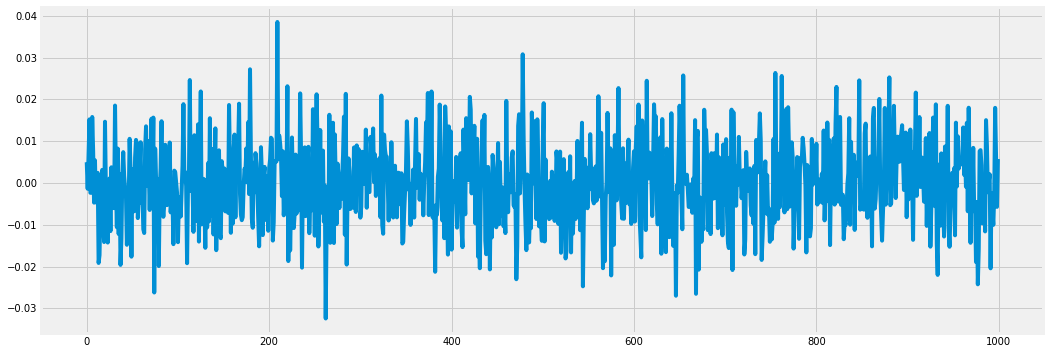

In [201]:
seed(42)
rcParams['figure.figsize'] = 16, 6
random_walk = normal(loc=0, scale=0.01, size=1000)
plt.plot(random_walk)
plt.show()

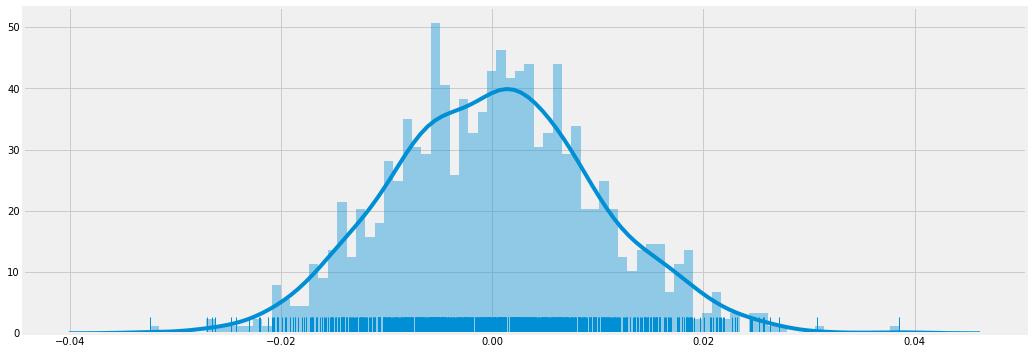

In [212]:
import seaborn as sns
sns.distplot(random_walk, kde=True, rug=True, bins=80)
plt.show()